# Fitting max-stable PCA to max-linear models

In [1]:
library(evd)
library(maxstablePCA)
library(dplyr)
library(GGally)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: ggplot2

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



### setup parameters and simulate data 

In [2]:
set.seed(7142128)
s <- 100

In [3]:
A1 <- matrix(
    c(
        6/10, 1 / 20, 1/10, 6 / 17, 6 / 18, 
        3 / 10, 15 / 20, 1 / 10, 3 / 17, 4 / 18, 
        1 / 10, 4 / 20, 8 / 10, 8 / 17, 8 / 18
     ), 
    5, 3
)

In [4]:
A1

0.6000000,0.3000000,0.1000000
0.0500000,0.7500000,0.2000000
0.1000000,0.1000000,0.8000000
0.3529412,0.1764706,0.4705882
0.3333333,0.2222222,0.4444444


In [5]:
Z1 <- matrix(rfrechet(30000), 10000, 3)
X1 <- t(maxmatmul(A1, t(Z1)))

In [6]:
X1trafo <- transform_unitpareto(X1)

In [7]:
summary(apply(X1trafo, 1, max))

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
    1.017     2.121     3.658    19.743     8.014 10000.000 

In [8]:
length(which(apply(X1trafo, 1, max) > s))

[1] 216

# Perform max-stable PCA for perfectly reconstrucable simulated data

In [9]:
maxPCAX1P1 <- max_stable_prcomp(X1trafo, p=1, s = s, n_initial_guesses = 15000, norm = "linfty")
maxPCAX1P2 <- max_stable_prcomp(X1trafo, p=2, s = s, n_initial_guesses = 15000, norm = "linfty")
maxPCAX1P3 <- max_stable_prcomp(X1trafo, p=3, s = s, n_initial_guesses = 15000, norm = "linfty")
maxPCAX1P4 <- max_stable_prcomp(X1trafo, p=4, s = s, n_initial_guesses = 15000, norm = "linfty")

In [10]:
maxPCAX1P3

$p
[1] 3

$d
[1] 5

$decoder_matrix
           [,1]       [,2]       [,3]
[1,] 1.34804255 0.30923580 0.04523401
[2,] 0.01767006 1.35651271 0.19396480
[3,] 0.04599736 0.07576909 1.46619183
[4,] 0.82679119 0.24147409 0.83212642
[5,] 0.78241050 0.41579434 0.78066715

$encoder_matrix
           [,1]       [,2]       [,3]        [,4]       [,5]
[1,] 0.74182039 0.19600779 0.07199331 0.091336178 0.08527584
[2,] 0.04600253 0.73719135 0.08504490 0.069297067 0.01755644
[3,] 0.04780269 0.06871423 0.68205411 0.002992819 0.14805921

$reconstr_matrix
           [,1]      [,2]       [,3]        [,4]       [,5]
[1,] 1.00000546 0.2642268 0.09705004 0.123125055 0.11495547
[2,] 0.06240302 1.0000094 0.13229449 0.094002352 0.02871828
[3,] 0.07008792 0.1007482 1.00002217 0.005250576 0.21708321
[4,] 0.61333057 0.1780126 0.56755525 0.075515948 0.12320398
[5,] 0.58040806 0.3065200 0.53245724 0.071462385 0.11558496

$loss_fctn_value
[1] 0.1083508

$optim_conv_status
[1] 4

$s
[1] 100

$starting_vals
$starting_v

In [11]:
round(maxPCAX1P3$decoder_matrix, 2)

1.35,0.31,0.05
0.02,1.36,0.19
0.05,0.08,1.47
0.83,0.24,0.83
0.78,0.42,0.78


In [12]:
round(maxPCAX1P3$encoder_matrix, 2)

0.74,0.20,0.07,0.09,0.09
0.05,0.74,0.09,0.07,0.02
0.05,0.07,0.68,0.00,0.15


In [13]:
round(maxPCAX1P3$reconstr_matrix, 2)

1.00,0.26,0.10,0.12,0.11
0.06,1.00,0.13,0.09,0.03
0.07,0.10,1.00,0.01,0.22
0.61,0.18,0.57,0.08,0.12
0.58,0.31,0.53,0.07,0.12


#### rescale the matrices such that the largest rowwise entries of $\hat W$ are equal to one

In [14]:
round(maxmatmul(maxPCAX1P3$decoder_matrix, diag(apply(maxPCAX1P3$encoder_matrix, 1, max))), 2)

1.00,0.23,0.03
0.01,1.00,0.13
0.03,0.06,1.00
0.61,0.18,0.57
0.58,0.31,0.53


In [15]:
round(t(apply(maxPCAX1P3$encoder_matrix, 1, function(z) z / max(z))), 2)

1.00,0.26,0.10,0.12,0.11
0.06,1.00,0.12,0.09,0.02
0.07,0.10,1.00,0.00,0.22


### elbow plot and pairplot to visually inspect fit 

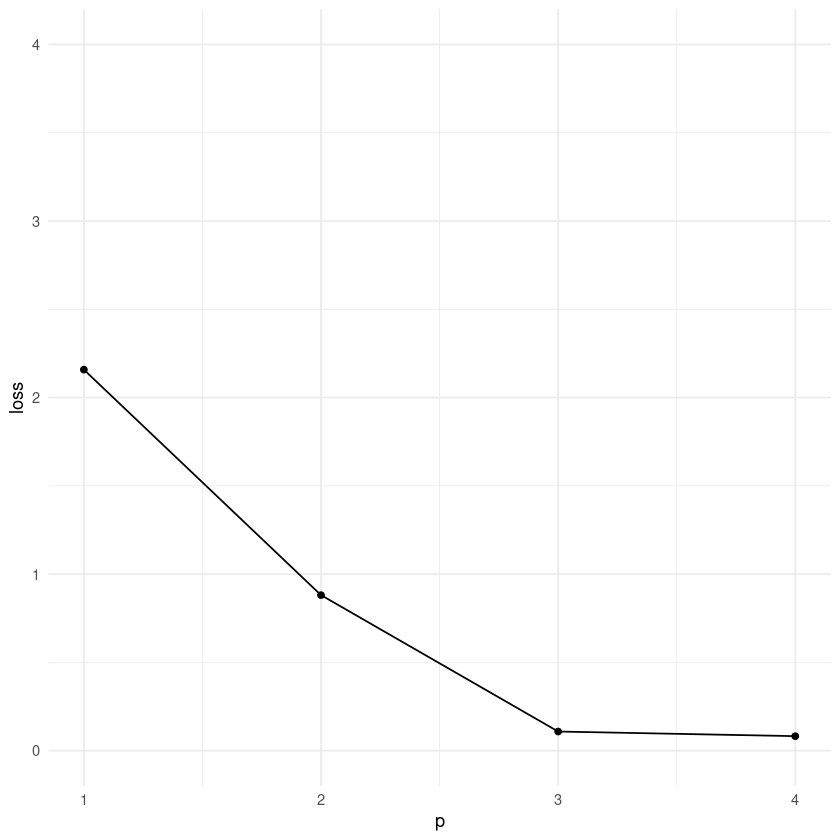

In [16]:
plotlossdatX1 <- data.frame(
    p = 1:4, 
    loss = c(
        maxPCAX1P1$loss_fctn_value,
        maxPCAX1P2$loss_fctn_value,
        maxPCAX1P3$loss_fctn_value,
        maxPCAX1P4$loss_fctn_value
    )
)

pe1 <- ggplot(aes(x = p, y = loss), data = plotlossdatX1) + geom_line() + geom_point() + ylim(0,4) + theme_minimal()
pe1

In [17]:
ggsave("mlm_lindep_elbow.pdf", pe1)

Saving 7 x 7 in image


In [18]:
rec1 <- t(maxmatmul(maxPCAX1P3$reconstr_matrix, t(X1)))

datX1 <- data.frame(X1)
datX1$is_rec = "original"
datrec1 <- data.frame(rec1)
datrec1$is_rec = "reconstruction"
names(datrec1) <- names(datX1)
plot_datX1 <- full_join(datX1, datrec1)

Joining with `by = join_by(X1, X2, X3, X4, X5, is_rec)`


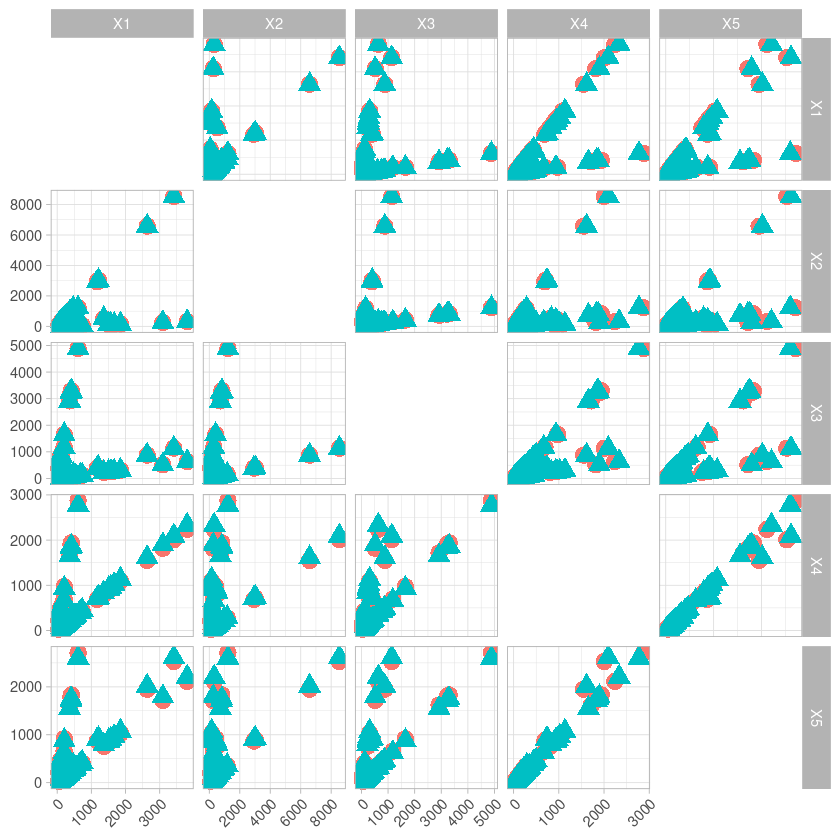

In [19]:
p1 <- ggpairs(
    plot_datX1, 
    aes(color = is_rec, shape = is_rec, size = 2),
    columns = 1:5,
    upper = list(continuous = "points", combo = "dot_no_facet"),
    diag = list(continuous = "blankDiag", discrete = "barDiag", na = "naDiag")
) + 
theme_light() +
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))
p1

In [20]:
ggsave("mlm_lindep.png", p1)

Saving 7 x 7 in image


# not perfectly reconstructable second model

In [21]:
A2 <- matrix(
    c(
        2/3, 2/3, 0, 0, 1 / 5, 
        0, 1/3, 2/3, 1/3, 3 / 5, 
        1 / 3, 0, 1/3, 2/3, 1 / 5
     ), 
    5, 3
)

In [22]:
A2

0.6666667,0.0000000,0.3333333
0.6666667,0.3333333,0.0000000
0.0000000,0.6666667,0.3333333
0.0000000,0.3333333,0.6666667
0.2000000,0.6000000,0.2000000


In [23]:
Z2 <- matrix(rfrechet(30000), 10000, 3)
X2 <- t(maxmatmul(A2, t(Z2)))
X2trafo <- transform_unitpareto(X2)

In [24]:
length(which(apply(X2trafo, 1, max) > s))

[1] 195

In [25]:
maxPCAX2P1 <- max_stable_prcomp(X2trafo, p=1, s = s, n_initial_guesses = 15000, norm = "linfty")
maxPCAX2P2 <- max_stable_prcomp(X2trafo, p=2, s = s, n_initial_guesses = 15000, norm = "linfty")
maxPCAX2P3 <- max_stable_prcomp(X2trafo, p=3, s = s, n_initial_guesses = 15000, norm = "linfty")
maxPCAX2P4 <- max_stable_prcomp(X2trafo, p=4, s = s, n_initial_guesses = 15000, norm = "linfty")

In [26]:
maxPCAX2P3

$p
[1] 3

$d
[1] 5

$decoder_matrix
            [,1]         [,2]         [,3]
[1,] 0.682371509 0.7856499745 0.0006934797
[2,] 0.001405535 1.1376249606 0.0017708992
[3,] 0.304802206 0.1068913700 1.1489626010
[4,] 1.261355289 0.0004540134 0.0033538690
[5,] 0.444003780 0.1766640546 1.0685341913

$encoder_matrix
             [,1]         [,2]         [,3]         [,4]        [,5]
[1,] 0.0005733894 1.580042e-05 0.0640500715 0.7928098575 0.002248232
[2,] 0.0008575232 8.790204e-01 0.0002315618 0.0006531885 0.001088386
[3,] 0.0298824810 3.148894e-02 0.1574021791 0.4049543888 0.935859170

$reconstr_matrix
             [,1]        [,2]         [,3]        [,4]        [,5]
[1,] 0.0006737131 0.690602352 0.0437059439 0.540990859 0.001534130
[2,] 0.0009755398 0.999995544 0.0002787434 0.001114322 0.001657312
[3,] 0.0343338531 0.093959694 0.1808492171 0.465277448 1.075267186
[4,] 0.0007232477 0.000399087 0.0807898965 1.000014907 0.003138749
[5,] 0.0319304527 0.155291307 0.1681896102 0.432707610 0.999

In [27]:
round(maxPCAX2P3$decoder_matrix, 2)

0.68,0.79,0.00
0.00,1.14,0.00
0.30,0.11,1.15
1.26,0.00,0.00
0.44,0.18,1.07


In [28]:
round(maxPCAX2P3$encoder_matrix, 2)

0.00,0.00,0.06,0.79,0.00
0.00,0.88,0.00,0.00,0.00
0.03,0.03,0.16,0.40,0.94


In [29]:
round(maxPCAX2P3$reconstr_matrix, 2)

0.00,0.69,0.04,0.54,0.00
0.00,1.00,0.00,0.00,0.00
0.03,0.09,0.18,0.47,1.08
0.00,0.00,0.08,1.00,0.00
0.03,0.16,0.17,0.43,1.00


#### rescale the matrices such that the largest rowwise entries of $\hat W$ are equal to one

In [30]:
round(maxmatmul(maxPCAX2P3$decoder_matrix, diag(apply(maxPCAX2P3$encoder_matrix, 1, max))), 2)

0.54,0.69,0.00
0.00,1.00,0.00
0.24,0.09,1.08
1.00,0.00,0.00
0.35,0.16,1.00


In [31]:
round(t(apply(maxPCAX2P3$encoder_matrix, 1, function(z) z / max(z))), 2)

0.00,0.00,0.08,1.00,0
0.00,1.00,0.00,0.00,0
0.03,0.03,0.17,0.43,1


### elbow plot and pairplot to visually inspect fit

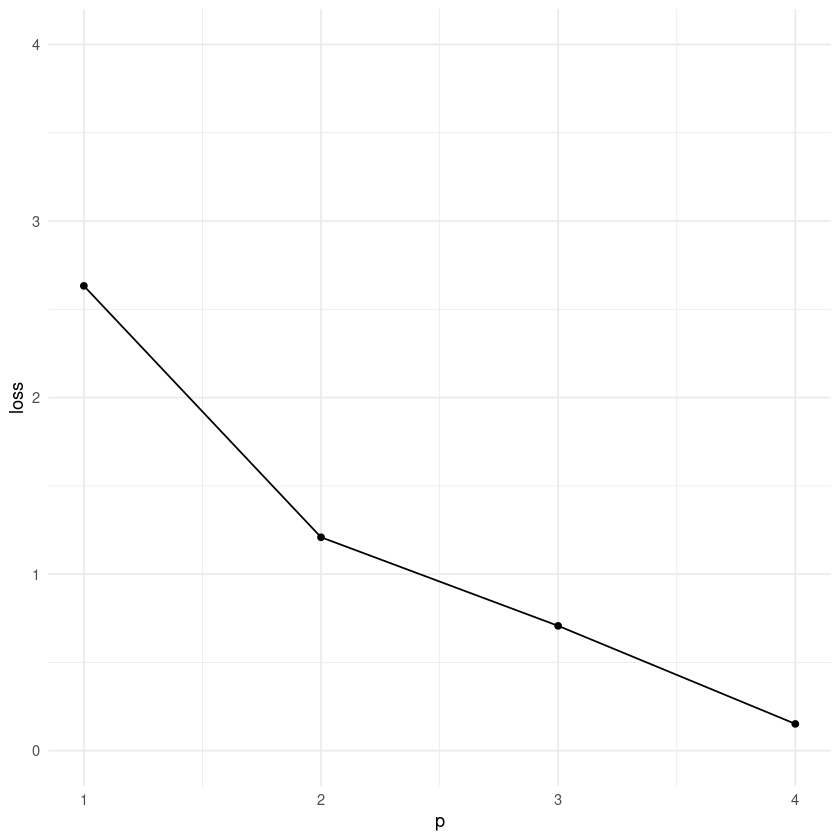

In [32]:
plotlossdatX2 <- data.frame(
    p = 1:4, 
    loss = c(
        maxPCAX2P1$loss_fctn_value,
        maxPCAX2P2$loss_fctn_value,
        maxPCAX2P3$loss_fctn_value,
        maxPCAX2P4$loss_fctn_value
    )
)

pe2 <- ggplot(aes(x = p, y = loss), data = plotlossdatX2) + geom_line() + geom_point() + ylim(0,4) + theme_minimal()
pe2

In [33]:
ggsave("mlm_nolindep_elbow.pdf", pe2)

Saving 7 x 7 in image


In [34]:
rec2 <- t(maxmatmul(maxPCAX2P3$reconstr_matrix, t(X2)))

datX2 <- data.frame(X2)
datX2$is_rec = "original"
datrec2 <- data.frame(rec2)
datrec2$is_rec = "reconstruction"
names(datrec2) <- names(datX2)
plot_datX2 <- full_join(datX2, datrec2)

Joining with `by = join_by(X1, X2, X3, X4, X5, is_rec)`


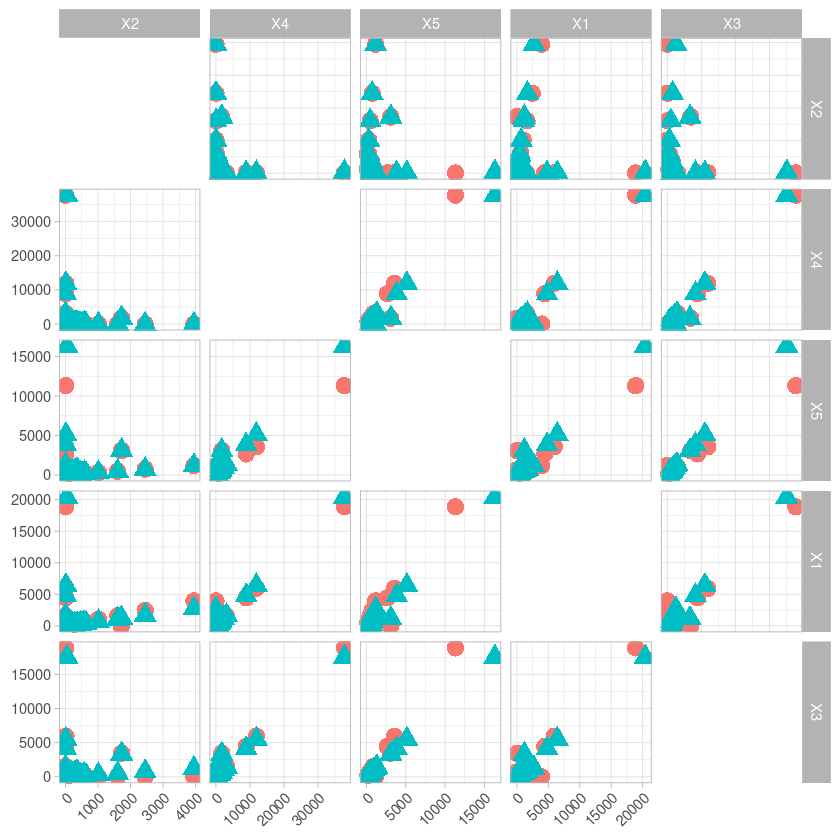

In [35]:
p2 <- ggpairs(
    plot_datX2, 
    aes(color = is_rec, shape = is_rec, size = 2),
    columns = c(2,4,5,1,3),
    upper = list(continuous = "points", combo = "dot_no_facet"),
    diag = list(continuous = "blankDiag", discrete = "barDiag", na = "naDiag")
) + 
theme_light() +
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

p2

In [36]:
ggsave("mlm_nolindep.png", p2)

Saving 7 x 7 in image
